In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import sys
import matplotlib.pyplot as plt
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [12]:
# Random seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Save the model at the end?
save_model = False

# Batch sizes for training and testing
batch_size = 64
test_batch_size = 14

# Training epochs (usually set to 10)
n_epochs = 2

# Learning rate
learning_rate = 1.0

# Decay rate for adjusting the learning rate
gamma = 0.7

# How many batches before logging training status
log_interval = 10

# Number of target classes in the MNIST data
num_classes = 10

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

# CUDA settings
if torch.cuda.is_available():
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [13]:
# The scaled mean and standard deviation of the MNIST dataset (precalculated)
data_mean = 0.1307
data_std = 0.3081

# Convert input images to tensors and normalize
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((data_mean,), (data_std,))
    ])

# Get the MNIST data from torchvision
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)

# Define the data loaders that will handle fetching of data
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [14]:
# Define the architecture of the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.lin1(x)
        x = F.softmax(x, dim=1)
        return x

In [15]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
# Send the model to the device (CPU or GPU)
model = Net().to(device)
model

Net(
  (lin1): Linear(in_features=784, out_features=10, bias=True)
)

In [18]:
# Define the optimizer to user for gradient descent
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

# Shrinks the learning rate by gamma every step_size
scheduler = ExponentialLR(optimizer, gamma=gamma)

# Train the model
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290816
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.846157
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.764242
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.724076
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.675945
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.608269


Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.608049
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.594587
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.680163
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.589021
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.592683
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.583058
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.591729
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.556479
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.579992
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.604280
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.694258
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.559289
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.626932
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.589301
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.616510
Train Epoch: 1 [13440/60000 (22%)]	Loss: 1.525984
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.623737
Train Epoch: 1 [14720/60000 (25%)]	Loss: 1.676250
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.554940
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.649518
Train Epoch: 

In [19]:
print(dataset1.targets)

tensor([5, 0, 4,  ..., 5, 6, 8])


In [20]:
def tohex(val, nbits):
  return hex((val + (1 << nbits)) % (1 << nbits))
def print_array(A, bits):
    for i in A:
        if (len(A.shape) > 1):
            for j in i:
                print(tohex(j, bits)[2:].zfill(bits//4), end=" ")
            print()
        else:
            print(tohex(i, bits)[2:].zfill(bits//4), end=" ")

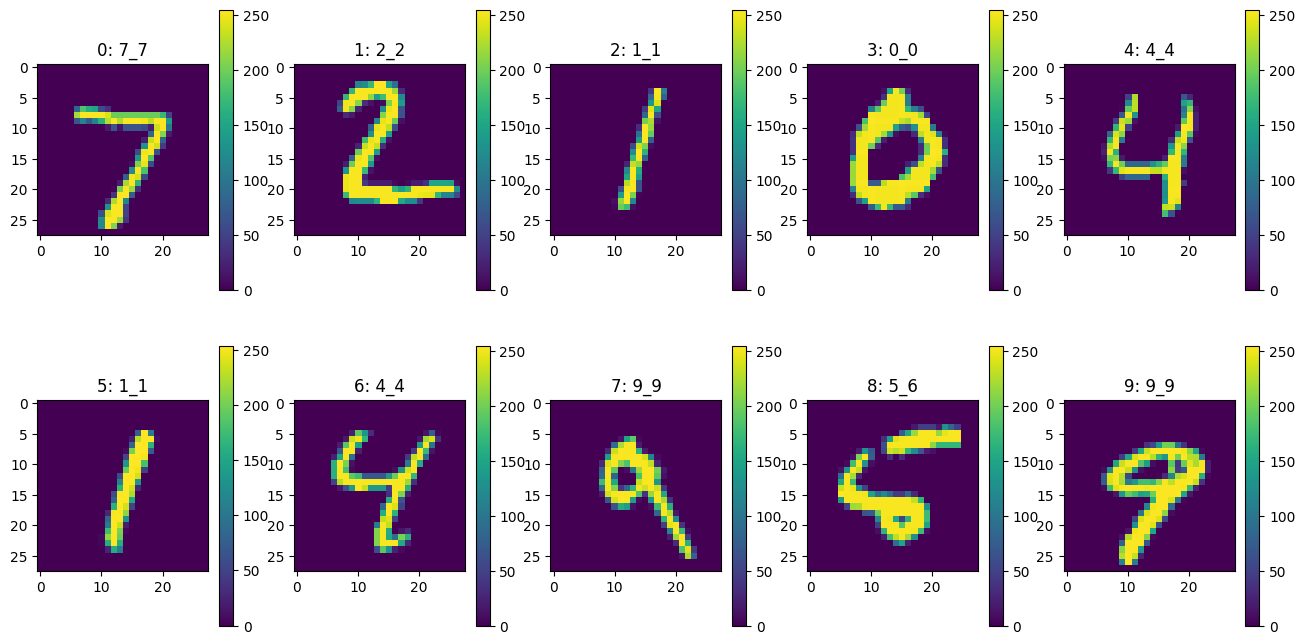

In [21]:
plt.figure(figsize=(16, 8))
for img in range(10):
  plt.subplot(2, 5, img+1)
  x_test = dataset2.data[img, :, :]
  y_test = dataset2.targets[img].detach().numpy()
  y_pred = model(dataset2.data[img].to(torch.float32).to(device)).argmax().detach().numpy()
  plt.imshow(x_test)
  plt.title(str(img) + ": " + str(y_test) + "_" + str(y_pred))
  plt.colorbar()

In [22]:
def print_array(A):
  for i in A:
    if (len(A.shape) > 1):
      for j in i:
        print("{:04x}".format(j & 0xffff), end=" ")
      print()
    else:
      print("{:04x}".format(i & 0xffff), end=" ")
images = [3, 2, 1, 18, 4, 15, 11, 0, 61, 9]
plt.figure(figsize=(16, 8))
for i in range(len(images)):
  img = images[i]
  plt.subplot(2, 5, i+1)
  x_test = dataset2.data[img, :, :]
  old_stdout = sys.stdout
  with open("image_new_{}.txt".format(i), "w") as sys.stdout:
    print_array(x_test.detach().numpy(), 8)
  sys.stdout = old_stdout
  y_test = dataset2.targets[img].detach().numpy()
  y_pred = model(dataset2.data[img].to(torch.float32).to(device)).argmax().detach().numpy()
  plt.imshow(x_test)
  plt.title(str(img) + ": " + str(y_test) + "_" + str(y_pred))
  plt.colorbar()

In [ ]:
if save_model:
    torch.save(model.state_dict(), "mnist_cnn_pytorch.ckpt")

In [ ]:
def save(a, name):
    a = np.array(a) * 10000
    a = a.astype(np.int16)

    print('weight shape: ', a.shape)
    old_stdout = sys.stdout
    with open(name + ".txt", "w") as sys.stdout:
        for i in a:
            if (len(a.shape) > 1):
                for j in i:
                    print('{:d} '.format(j), end='')
                print()
            else:
                print('{:d} '.format(i), end='')
    sys.stdout = old_stdout

In [ ]:
print(model.lin1.bias.detach().numpy())
save(model.lin1.bias.detach().numpy(), "bias2")

[ 0.00099403 -0.07851407  0.01392994  0.03716532 -0.03272219  0.07787665
 -0.01547681 -0.02487389 -0.04032503 -0.02146326]
weight shape:  (10,)


In [ ]:
print(model.lin1.weight.detach().numpy().T)
save(model.lin1.weight.detach().numpy().T, "weight2")

[[ 0.02954763  0.00763043 -0.00072338 ...  0.0111871   0.00808979
  -0.01525778]
 [ 0.02049326 -0.00489414  0.02114862 ... -0.03603221  0.02808734
   0.01756463]
 [ 0.00668024  0.0034676  -0.02545485 ...  0.02595308  0.0174943
   0.0134935 ]
 ...
 [-0.02704675  0.05115715 -0.03875545 ... -0.03547022 -0.01756105
  -0.00819416]
 [ 0.03847111  0.05452135 -0.00284767 ... -0.02657634 -0.01970426
   0.0315943 ]
 [ 0.03703321  0.03688729  0.01084979 ...  0.03153852  0.0296776
   0.01894951]]
weight shape:  (784, 10)


In [ ]:
def read_save(name, transpose, bits):
    f = open(name + ".txt", "r")
    a = np.array([line.split() for line in f], dtype=np.float64)
    #print(np.amax(a))
    #a = a*(2**(data_width-1))/14600
    #print(np.amax(a))
    a = a.astype(np.int64)

    old_stdout = sys.stdout
    with open(name + ".hex.", "w") as sys.stdout:
        if (transpose):
            print_array(a.T, bits)
        else:
            print_array(a, bits)
    sys.stdout = old_stdout

read_save("weight2", False, 16)
read_save("bias2", False, 16)

In [ ]:
f = open("weight2.txt", "r")
w = np.array([line.split() for line in f], dtype=np.int64)

f = open("bias2.txt", "r")
b = np.array([line.split() for line in f], dtype=np.int64)

with open('images2.hex', 'r') as f:
    # Читаем содержимое файла в виде байтов
    for i in range(10):
        img = f.readline()
        img = np.array([int(b, 16) for b in img.split()], dtype=np.int16)
        print(np.matmul(img, w))
        res = np.matmul(img, w)+b
        print(res)
        print(np.argmax(res))
    
    f.close()

[ 10111360 -29616224 -10942140 -11113312 -23655448 -10670889  -8313626
 -12916062  -8351712 -15293599]
[[ 10111369 -29617009 -10942001 -11112941 -23655775 -10670111  -8313780
  -12916310  -8352115 -15293813]]
0
[-11380140   5385305   -519152  -2089665  -6338242  -7705830  -2846137
  -4946844    459590  -4799181]
[[-11380131   5384520   -519013  -2089294  -6338569  -7705052  -2846291
   -4947092    459187  -4799395]]
1
[  1280946 -11060552   9545578    273302 -26101846  -4711889   1700023
 -34650585   -792877 -22254945]
[[  1280955 -11061337   9545717    273673 -26102173  -4711111   1699869
  -34650833   -793280 -22255159]]
2
[-12704029 -12391589  -7907469  -1288170 -10558111 -12375227  -7211935
 -18804866  -6463566 -14421433]
[[-12704020 -12392374  -7907330  -1287799 -10558438 -12374449  -7212089
  -18805114  -6463969 -14421647]]
3
[ -5803234 -14891782  -7414419 -13382889   3905540 -12810529  -4271171
  -6925376  -2769581   -268039]
[[ -5803225 -14892567  -7414280 -13382518   3905213 -